# Set up

In [1]:
import pandas as pd
import numpy as np
import tqdm as tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import pyro.distributions as dist

import math

# Read Data

In [2]:
Y_data_train = pd.read_csv('../Data/Data20260110/Y_data_train_Final.csv', header=None, delimiter=',')
# Y_data_train = Y_data_train.drop(columns=[Y_data_train.columns[-1]])

Y_data_test = pd.read_csv('../Data/simulation_results_test.txt', header=None, delimiter=' ')
Y_data_test = Y_data_test.drop(columns=[Y_data_test.columns[-1]])

In [ ]:
Y_data_max = pd.read_csv('simulation_results_5_max.txt', header=None, delimiter=' ')
Y_data_max = Y_data_max.drop(columns=[Y_data_max.columns[-1]])

In [ ]:
Y_data_extra = pd.read_csv('../simulation_results_Extra.txt', header=None, delimiter=' ')
Y_data_extra = Y_data_extra.drop(columns=[Y_data_extra.columns[-1]])

In [3]:
RealCase = pd.read_csv('RealCase.csv', header=None, delimiter=',')

In [4]:
df_new = Y_data_train.drop(Y_data_train.columns[-18:], axis=1)
Y_data_train = df_new.drop(df_new.columns[17], axis=1)

In [5]:
df_new = Y_data_test.drop(Y_data_test.columns[-18:], axis=1)
Y_data_test = df_new.drop(df_new.columns[17], axis=1)

In [ ]:
# df_new = Y_data_max.drop(Y_data_max.columns[-18:], axis=1)
# Y_data_max = df_new.drop(df_new.columns[17], axis=1)

In [ ]:
# df_new = Y_data_extra.drop(Y_data_extra.columns[-18:], axis=1)
# Y_data_extra = df_new.drop(df_new.columns[17], axis=1)

In [ ]:
Y_data_train.shape

In [ ]:
RealCase

## Save

In [6]:
np.savetxt("RealCase_Y_train.csv", Y_data_train, delimiter=",", fmt="%.8f")
np.savetxt("RealCase_Y_test.csv", Y_data_test, delimiter=",", fmt="%.8f")

## Check

In [ ]:
((RealCase.abs().values >= Y_data_max.abs().values)).sum(axis=1)

# Standard

In [7]:
scaler = StandardScaler()
Y_data_train_standardized = pd.DataFrame(scaler.fit_transform(Y_data_train), columns=Y_data_train.columns).values

Y_data_test_standardized = pd.DataFrame(scaler.transform(Y_data_test), columns=Y_data_test.columns).values

RealCase_standardized = pd.DataFrame(scaler.transform(RealCase), columns=RealCase.columns).values

In [8]:
np.savetxt("RealCase_Y_train_std.csv", Y_data_train_standardized, delimiter=",", fmt="%.8f")
np.savetxt("RealCase_Y_test_std.csv", Y_data_test_standardized, delimiter=",", fmt="%.8f")
np.savetxt("RealCase_Y_std.csv", RealCase_standardized, delimiter=",", fmt="%.8f")

# Mapping back

In [ ]:
X_train = pd.read_csv('../Data/Data20260110/X_train_Final.csv', header=None, delimiter=',').values


m = X_train.shape[0]

mapping = {
    0: [4, 16],
    1: [5, 17],
    2: [10, 22],
    3: [11, 23],
    4: [8, 6, 20, 18],
    5: [9, 7, 21, 19],
    6: [2, 0, 14, 12],
    7: [3, 1, 15, 13],
    8: [24, 26, 28, 30, 32],
    9: [25, 27, 29, 31, 33]
}

X_all_recovered = np.zeros((m, len(mapping)))


for orig_col, new_cols in mapping.items():

    X_all_recovered[:, orig_col] = X_train[:, new_cols].mean(axis=1)

X_train = np.around(X_all_recovered, decimals=4)

In [ ]:
X_test = pd.read_csv('../Data/X_test.txt', header=None, delimiter=' ').values


m = X_test.shape[0]

mapping = {
    0: [4, 16],
    1: [5, 17],
    2: [10, 22],
    3: [11, 23],
    4: [8, 6, 20, 18],
    5: [9, 7, 21, 19],
    6: [2, 0, 14, 12],
    7: [3, 1, 15, 13],
    8: [24, 26, 28, 30, 32],
    9: [25, 27, 29, 31, 33]
}

X_all_recovered = np.zeros((m, len(mapping)))


for orig_col, new_cols in mapping.items():

    X_all_recovered[:, orig_col] = X_test[:, new_cols].mean(axis=1)

X_test = np.around(X_all_recovered, decimals=4)

In [ ]:
np.savetxt("RealCase_X_train.csv", X_train, delimiter=",", fmt="%.4f")
np.savetxt("RealCase_X_test.csv", X_test, delimiter=",", fmt="%.4f")

# PCA

In [9]:
def _sign_flip_scores(components, scores):

    comps = components.copy()
    Z = scores.copy()
    for i in range(comps.shape[0]):
        j = np.argmax(np.abs(comps[i]))  # 该成分绝对值最大的载荷索引
        if comps[i, j] < 0:              # 若为负则整体翻转
            comps[i] *= -1
            Z[:, i] *= -1
    return comps, Z

def split_and_apply_pca(train_data, test_data, variance_threshold=0.999,
                        svd_solver='full', random_state=0):

    # 1) 拆分第一列
    train_first_col = train_data[:, 0].reshape(-1, 1)
    test_first_col  = test_data[:, 0].reshape(-1, 1)

    train_remaining = train_data[:, 1:]
    test_remaining  = test_data[:, 1:]

    # 2) 先用完整 PCA 拟合以取累计方差（确定性求解器 & 固定 random_state）
    pca_full = PCA(svd_solver=svd_solver, random_state=random_state)
    pca_full.fit(train_remaining)
    cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

    # 3) 选取主成分个数
    n_components = int(np.argmax(cumulative_variance >= variance_threshold) + 1)

    # 4) 用 n_components 重新拟合（同样保证确定性）
    pca = PCA(n_components=n_components, svd_solver=svd_solver, random_state=random_state)
    train_scores = pca.fit_transform(train_remaining)  # Z_train
    test_scores  = pca.transform(test_remaining)       # Z_test

    # 5) 进行“符号固定”，消除 ± 号的随机性
    comps_fixed, train_scores_fixed = _sign_flip_scores(pca.components_, train_scores)
    _,           test_scores_fixed  = _sign_flip_scores(pca.components_, test_scores)

    # （可选）若你希望把固定后的 components 回写给 pca 对象，可取消下面两行注释：
    # pca.components_ = comps_fixed
    # 注意：scikit-learn 并不依赖 components_ 的符号唯一性，回写仅用于记录

    # 6) 合并回第一列
    train_final = np.hstack((train_first_col, train_scores_fixed))
    test_final  = np.hstack((test_first_col,  test_scores_fixed))

    return train_final, test_final, n_components


In [20]:
Y_train_final, Y_test_final, n_components = split_and_apply_pca(
    Y_data_train_standardized,
    RealCase_standardized,
    variance_threshold=0.999
)

In [21]:
n_components

20

In [12]:
Y_test_final

array([[ 0.82101606, -5.01543192, -0.34568061, -1.02974243,  1.67722292,
        -1.44078128,  0.51998735,  1.16701686,  0.43115622,  0.74090527,
         1.04714988, -0.59367321,  0.927355  , -0.78569632, -0.63613977,
         0.16232307,  0.70583902, -0.03896613,  0.18001569, -0.28047279,
         0.23129018]])

In [ ]:
col_min = np.nanmin(Y_train_final, axis=0)
col_max = np.nanmax(Y_train_final, axis=0)


((Y_test_final <= col_min) & (Y_test_final >= col_max)).sum(axis=1)

In [22]:
np.savetxt("RealCase_Y_pca.csv", Y_test_final, delimiter=",", fmt="%.8f")

In [ ]:
np.savetxt("RealCase_Y_test_pca.csv", Y_test_final, delimiter=",", fmt="%.8f")
np.savetxt("RealCase_Y_train_pca.csv", Y_train_final, delimiter=",", fmt="%.8f")

In [ ]:
Y_train_final

In [ ]:
Y_train_final

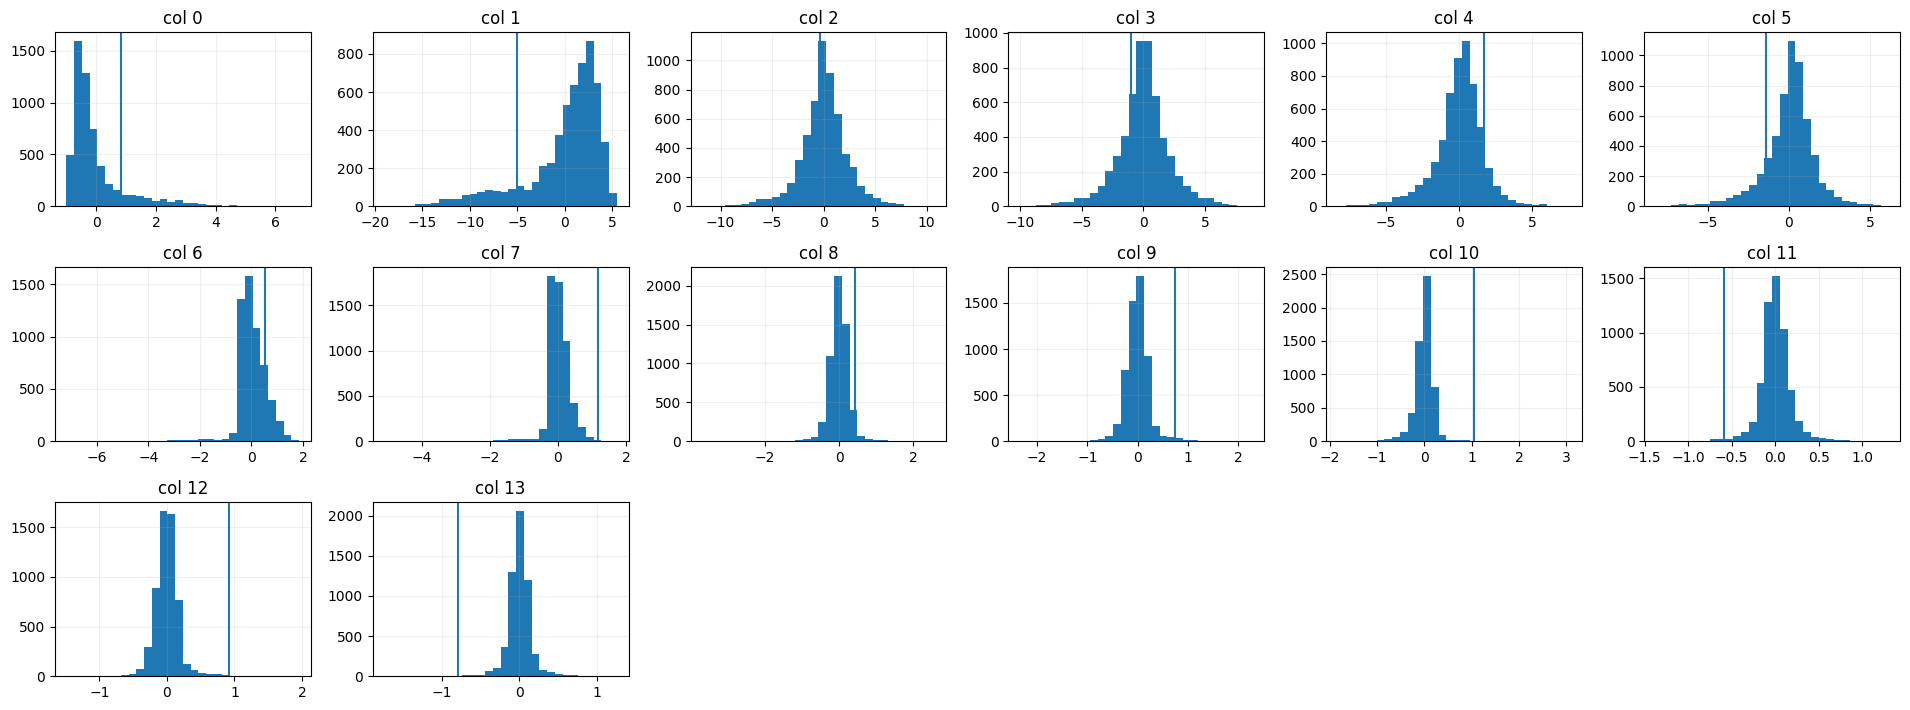

In [19]:
def plot_hist_grid(Y, real, start=0, num=24, ncols=6, bins=30):
    real = np.asarray(real).squeeze()
    if real.ndim == 0:
        real = real[None]

    p = Y.shape[1]
    end = min(p, start + num)
    idxs = list(range(start, end))

    nrows = math.ceil(len(idxs) / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(3.2*ncols, 2.4*nrows), squeeze=False)

    for k, j in enumerate(idxs):
        r, c = divmod(k, ncols)
        ax = axes[r][c]
        ax.hist(Y[:, j], bins=bins)
        ax.axvline(real[j])  # RealCase 的位置
        ax.set_title(f"col {j}")
        ax.grid(alpha=0.2)

    # 多余子图关掉
    for k in range(len(idxs), nrows*ncols):
        r, c = divmod(k, ncols)
        axes[r][c].axis("off")

    plt.tight_layout()
    plt.show()

# real = Y_test_final.squeeze()
plot_hist_grid(Y_train_final, Y_test_final, start=0,  num=33)




In [ ]:
import numpy as np
from sklearn.decomposition import PCA

def _sign_flip_components_and_scores(components, scores):
    """
    固定PCA符号：对每个PC，找到绝对值最大的载荷所在特征维 j；
    若该载荷为负，则整体翻转该PC的components与scores。
    返回：comps_fixed, scores_fixed, signs(长度=K, 元素为±1)
    """
    comps = components.copy()              # (K, D)
    K = comps.shape[0]
    signs = np.ones(K, dtype=float)

    for i in range(K):
        j = np.argmax(np.abs(comps[i]))
        if comps[i, j] < 0:
            signs[i] = -1.0
            comps[i] *= -1.0

    Z_fixed = scores * signs[None, :]      # (N, K)
    return comps, Z_fixed, signs


def _pca_coverage_detection(
    train_scores_fixed,
    test_scores_fixed,
    comps_fixed,
    pca_obj,
    train_remaining,
    test_remaining,
    q_low=0.005,
    q_high=0.995,
    topk_features=10,
):
    """
    基于训练集PC得分分位数边界检测测试集超界，并将超界部分反投影回原始特征维。

    返回 report 字典，包含：
      - bounds_low/high: (K,)
      - pc_out_mask: (n_test, K) bool
      - delta_z: (n_test, K)
      - delta_x_centered: (n_test, D_remaining)  # 原始特征空间(中心化后)的“驱动偏离量”
      - per_sample_top_features: list[dict]      # 每个测试样本的topk原始维贡献
      - global_top_features: list[tuple]         # 全局(在超界样本上)平均贡献排序
      - (optional) T2/Q 及其特征贡献
    """
    Ztr = train_scores_fixed
    Zte = test_scores_fixed
    K = Ztr.shape[1]
    Drem = train_remaining.shape[1]

    # 1) 训练覆盖边界（按PC维）
    bounds_low = np.quantile(Ztr, q_low, axis=0)   # (K,)
    bounds_high = np.quantile(Ztr, q_high, axis=0) # (K,)

    # 2) 哪些测试样本在哪些PC维超界
    pc_out_mask = (Zte < bounds_low[None, :]) | (Zte > bounds_high[None, :])  # (n_test, K)
    any_out = pc_out_mask.any(axis=1)                                        # (n_test,)

    # 3) 计算超界部分 delta_z（只保留超界“超出去”的那一截）
    Zte_clipped = np.clip(Zte, bounds_low[None, :], bounds_high[None, :])
    delta_z = Zte - Zte_clipped  # (n_test, K) 超界维非零

    # 4) 将 delta_z 反投影到原始特征空间（中心化空间）
    # components 形状 (K, Drem)，故 delta_x = delta_z @ components -> (n_test, Drem)
    delta_x_centered = delta_z @ comps_fixed

    # 5) 每个测试样本：原始维贡献TopK（按 |delta_x| 排序）
    per_sample_top = []
    for i in range(Zte.shape[0]):
        if not any_out[i]:
            per_sample_top.append({
                "sample_idx": i,
                "out_pcs": [],
                "top_features": []
            })
            continue

        out_pcs = np.where(pc_out_mask[i])[0].tolist()
        contrib = delta_x_centered[i]  # (Drem,)
        order = np.argsort(-np.abs(contrib))[:topk_features]

        # 注意：这里的 feature_idx 是 “remaining” 内部索引 0..Drem-1
        # 如果你要映射回原 train_data 的原始列：原始列号 = feature_idx + 1（因为第0列拆出）
        top_feats = [{
            "feature_idx_remaining": int(j),
            "feature_idx_original": int(j + 1),
            "contrib": float(contrib[j]),
            "abs_contrib": float(abs(contrib[j]))
        } for j in order]

        per_sample_top.append({
            "sample_idx": i,
            "out_pcs": out_pcs,
            "top_features": top_feats
        })

    # 6) 全局：在“超界样本”上按平均 |delta_x| 排序
    if np.any(any_out):
        mean_abs = np.mean(np.abs(delta_x_centered[any_out]), axis=0)  # (Drem,)
        order_g = np.argsort(-mean_abs)[:topk_features]
        global_top = [{
            "feature_idx_remaining": int(j),
            "feature_idx_original": int(j + 1),
            "mean_abs_contrib": float(mean_abs[j])
        } for j in order_g]
    else:
        global_top = []

    # 7) （可选）T^2 与 Q(SPE) 及其特征贡献：帮助区分“子空间内远离”vs“子空间外新结构”
    # PCA 的 transform: Z = (X - mean) @ components.T
    # 在中心化空间：Xc = X - mean，Xhat_c = Z @ components
    Xc_te = test_remaining - pca_obj.mean_[None, :]        # (n_test, Drem)
    Xhat_c = Zte @ comps_fixed                              # (n_test, Drem)
    resid = Xc_te - Xhat_c
    Q = np.sum(resid**2, axis=1)                            # (n_test,)
    c_Q = resid**2                                          # (n_test, Drem) 逐特征贡献

    lam = np.maximum(pca_obj.explained_variance_, 1e-12)    # (K,)
    T2 = np.sum((Zte**2) / lam[None, :], axis=1)            # (n_test,)

    # T^2 二次型分解：T2 = x^T M x, 贡献 c_T2_i = x_i (Mx)_i
    P = comps_fixed.T                                       # (Drem, K)
    M = P @ np.diag(1.0 / lam) @ P.T                        # (Drem, Drem)
    Mx = Xc_te @ M.T                                        # (n_test, Drem)
    c_T2 = Xc_te * Mx                                       # (n_test, Drem)

    report = {
        "q_low": q_low,
        "q_high": q_high,
        "bounds_low": bounds_low,
        "bounds_high": bounds_high,
        "pc_out_mask": pc_out_mask,
        "any_out": any_out,
        "delta_z": delta_z,
        "delta_x_centered": delta_x_centered,
        "per_sample_top_features": per_sample_top,
        "global_top_features": global_top,
        "T2": T2,
        "c_T2": c_T2,
        "Q": Q,
        "c_Q": c_Q,
    }
    return report


def split_and_apply_pca(
    train_data,
    test_data,
    variance_threshold=0.999,
    svd_solver='full',
    random_state=0,
    # --- detection config ---
    return_report=False,
    q_low=0.005,
    q_high=0.995,
    topk_features=10
):
    # 1) 拆分第一列
    train_first_col = train_data[:, 0].reshape(-1, 1)
    test_first_col  = test_data[:, 0].reshape(-1, 1)

    train_remaining = train_data[:, 1:]
    test_remaining  = test_data[:, 1:]

    # 2) 先用完整 PCA 拟合以取累计方差（确定性求解器 & 固定 random_state）
    pca_full = PCA(svd_solver=svd_solver, random_state=random_state)
    pca_full.fit(train_remaining)
    cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

    # 3) 选取主成分个数
    n_components = int(np.argmax(cumulative_variance >= variance_threshold) + 1)

    # 4) 用 n_components 重新拟合（同样保证确定性）
    pca = PCA(n_components=n_components, svd_solver=svd_solver, random_state=random_state)
    train_scores = pca.fit_transform(train_remaining)  # Z_train
    test_scores  = pca.transform(test_remaining)       # Z_test

    # 5) 进行“符号固定”，消除 ± 号的随机性（关键：test 用同一 signs）
    comps_fixed, train_scores_fixed, signs = _sign_flip_components_and_scores(pca.components_, train_scores)
    test_scores_fixed = test_scores * signs[None, :]

    # 6) 合并回第一列
    train_final = np.hstack((train_first_col, train_scores_fixed))
    test_final  = np.hstack((test_first_col,  test_scores_fixed))

    if not return_report:
        return train_final, test_final, n_components

    # 7) 检测：测试集哪些PC超出训练覆盖，并归因到原始维
    report = _pca_coverage_detection(
        train_scores_fixed=train_scores_fixed,
        test_scores_fixed=test_scores_fixed,
        comps_fixed=comps_fixed,
        pca_obj=pca,
        train_remaining=train_remaining,
        test_remaining=test_remaining,
        q_low=q_low,
        q_high=q_high,
        topk_features=topk_features,
    )

    return train_final, test_final, n_components, report


In [ ]:
train_pca, test_pca, k, report = split_and_apply_pca(
    Y_data_train_standardized, RealCase_standardized,
    variance_threshold=0.999,
    return_report=True,
    q_low=0.005, q_high=0.995,
    topk_features=8
)

# 1) 哪些测试样本在PC上超界
out_samples = np.where(report["any_out"])[0]          # 测试集中“有任一PC超界”的样本索引
pc_out_mask = report["pc_out_mask"]                   # (n_test, K) bool

# 2) 全局：最驱动偏离的原始特征（按 mean |delta_x|）
report["global_top_features"]
# 每个元素包含 feature_idx_original（对应 train_data 的列号）和 mean_abs_contrib

# 3) 单样本：i 号测试样本具体是哪些原始维导致偏离
i = int(out_samples[0])
report["per_sample_top_features"][i]


# End